# Dan's code: fitting a GP to data.

In [1]:
%matplotlib inline

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
clusters = pd.read_csv("../data/dbf12.csv")
bench = pd.read_csv("../data/Gyro_Benchmark-Field_Stars.csv")
bench = bench.iloc[bench.Age.values > 0.]
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# plt.figure(figsize=(8, 5), dpi=200)
# # plt.scatter(k.bprp_dered, k.abs_G, c=k.kinematic_age, s=1, vmin=0, vmax=10, alpha=.1)
# plt.scatter(kin.bprp_dered, kin.abs_G, c=kin.kinematic_age, s=1, vmin=0, vmax=10, alpha=.2)
# plt.colorbar()
# plt.ylim(12, 0)

Text(0, 0.5, '$\\mathrm{P_{rot}~[days]}$')

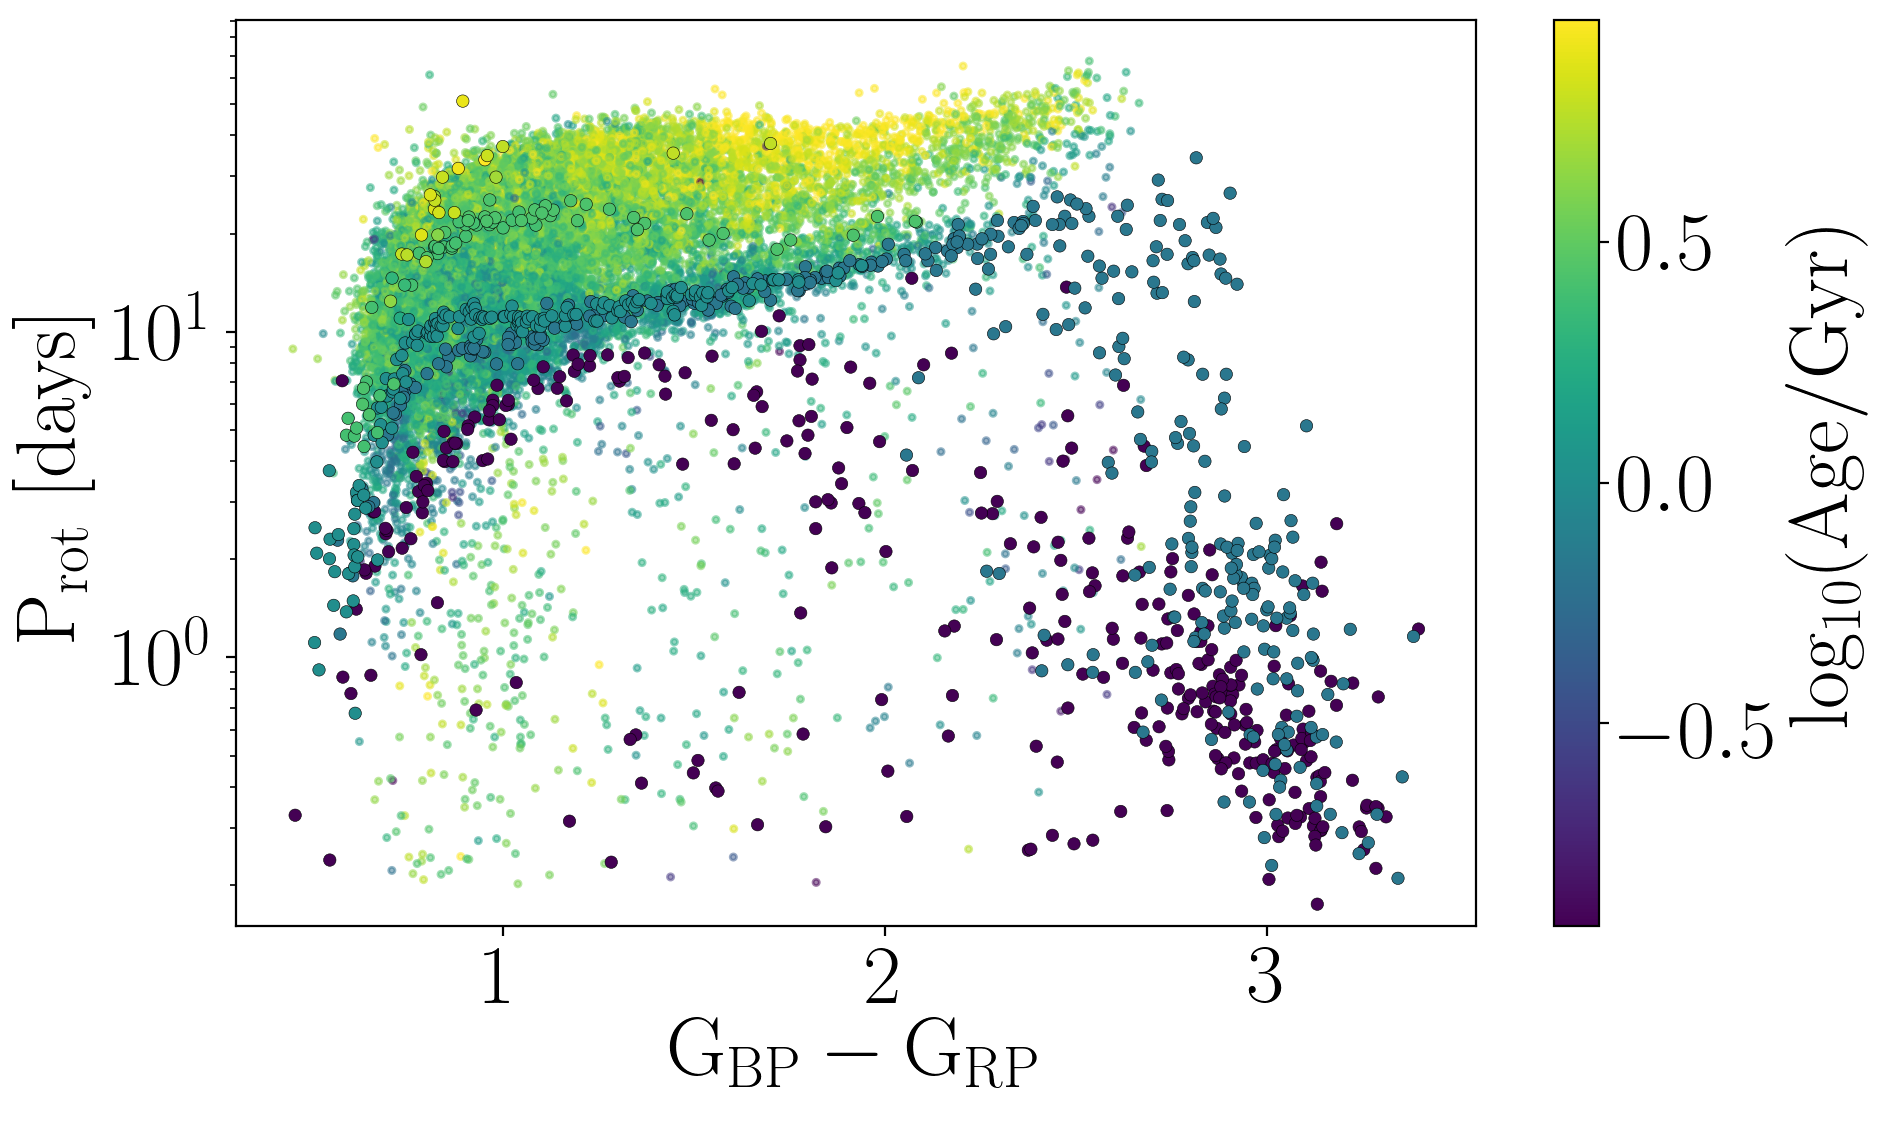

In [5]:
fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = np.log10(min(clusters.age_gyr)), np.log10(max(bench.Age))
plt.scatter(kin.bprp_dered, kin.Prot, c=np.log10(kin.kin_age_lucy),  #kinematic_age),
           s=5, alpha=.5, vmin=vmin, vmax=vmax)
plt.scatter(clusters["(BP-RP)0"], clusters.prot, c=np.log10(clusters.age_gyr),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)
plt.scatter(bench["BP-RP"], bench.Prot, c=np.log10(bench.Age),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)
plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")

In [6]:
# fig = plt.figure(figsize=(10, 6), dpi=200)
# vmin, vmax = min(clusters.age_gyr), max(bench.Age)
# plt.scatter(kin.color_teffs, kin.Prot, c=kin.kin_age_lucy,
#            s=5, alpha=.5, vmin=vmin, vmax=vmax)
# plt.scatter(clusters["teff"], clusters.prot, c=clusters.age_gyr,
#             s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.3)
# plt.scatter(bench["Teff_1"], bench.Prot, c=bench.Age,
#             s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.3)
# plt.yscale("log")
# plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
# plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
# plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7000, 3000)

In [7]:
# mearth = pd.read_csv("../../data/mearth_kinematic_ages.csv")
# mteffs = pd.read_csv("../../data/mearth_teffs.csv")
# mdf = pd.merge(mearth, mteffs, on="prot", suffixes=["", "_"])
# mask = (mdf.teff.values < 4000) & (mdf.prot.values > 30) & (mdf.kin_age.values > 5) & (mdf.teff.values > 2800)
# mask &= np.isfinite(mdf.teff.values) & np.isfinite(mdf.kin_age.values) & np.isfinite(mdf.prot.values)
# mdf = mdf.iloc[mask][::1]

For now, let's take out the cluster M dwarfs and the outliers in the Pleiades.

Text(0, 0.5, '$\\mathrm{P_{rot}~[days]}$')

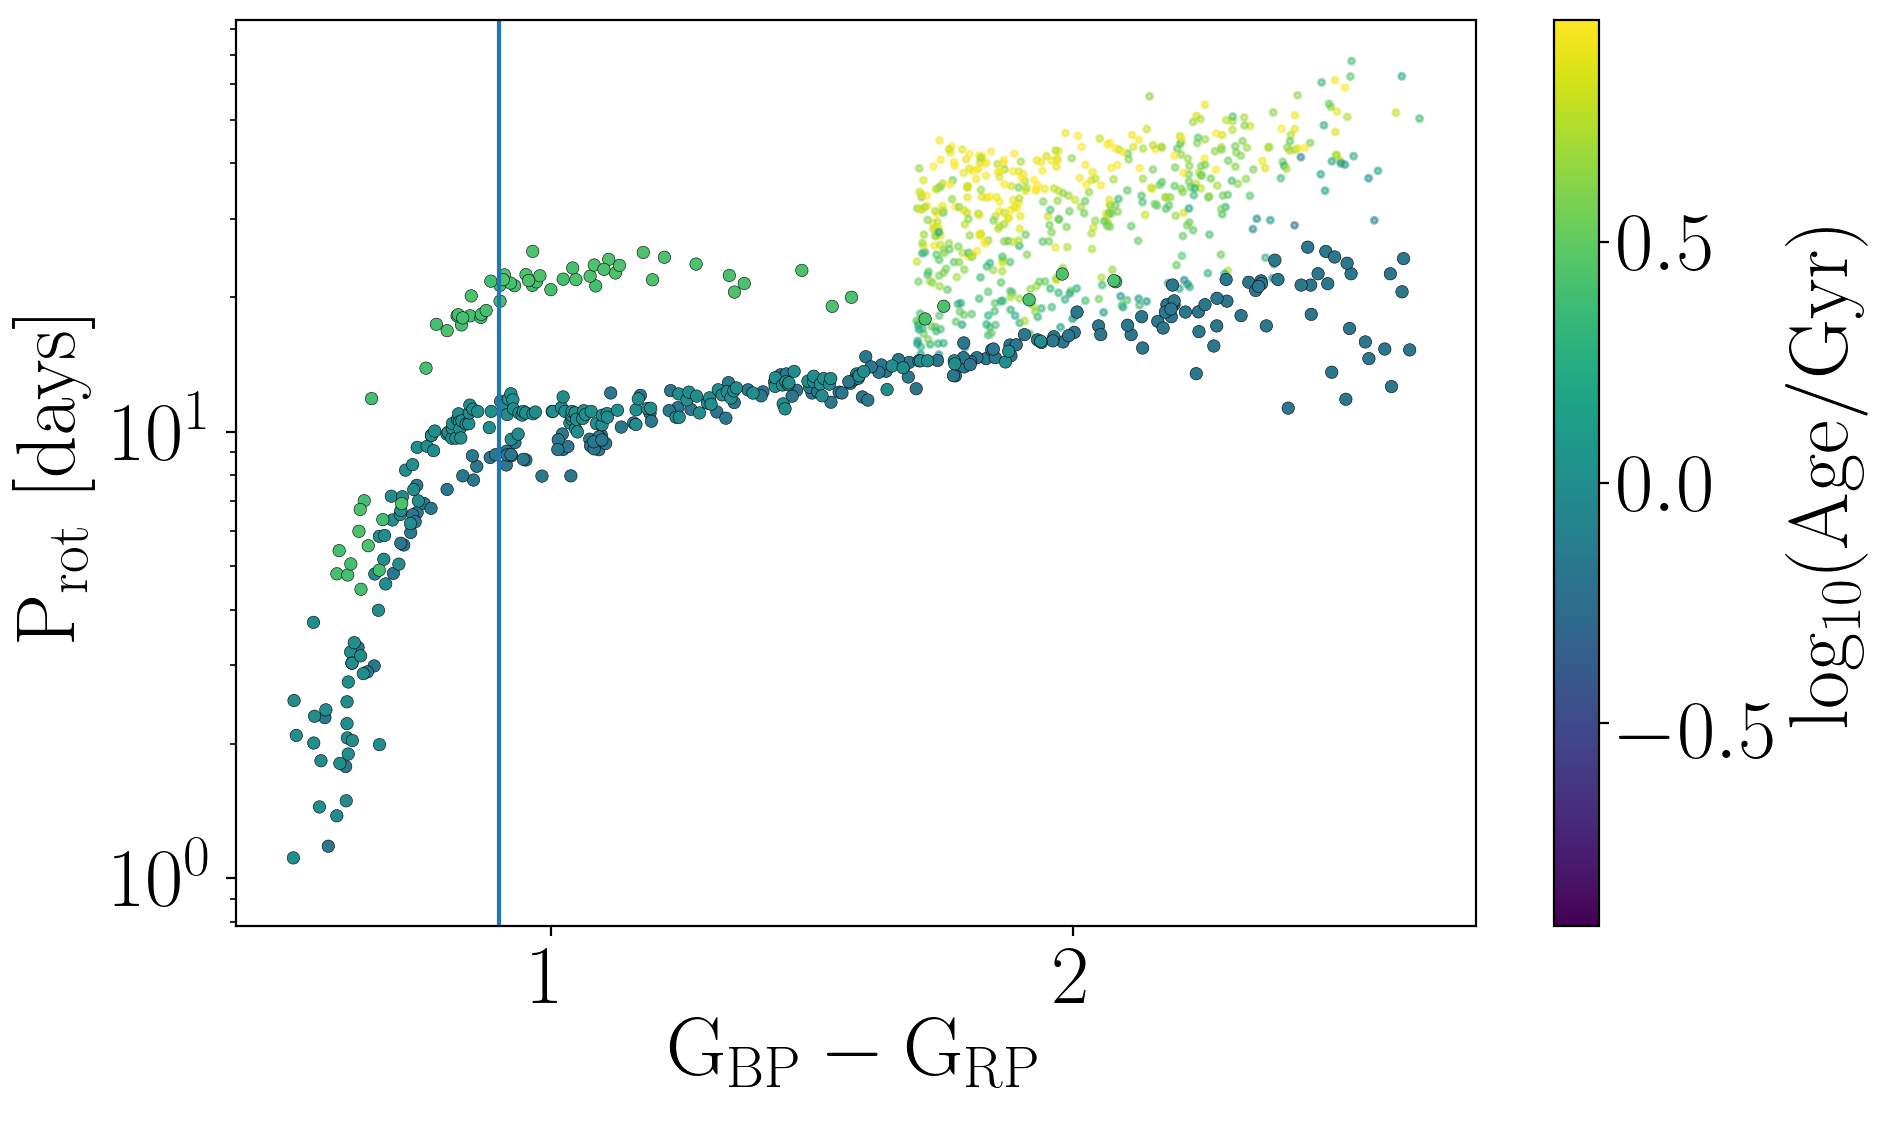

In [48]:
# Do all sorts of cuts.
ms = (clusters["(BP-RP)0"].values > 1.5) & (clusters.prot.values < 11)
not_fast = (clusters.prot.values[~ms] > 1) & (clusters["(BP-RP)0"].values[~ms] < 2.7)
no_pleiades = clusters.age_gyr.values[~ms][not_fast] > 0.2
old = (kin.age.values > .7) & (kin.bprp_dered.values > 1.7)
sub_sample = 3

fig = plt.figure(figsize=(10, 6), dpi=200)
vmin, vmax = np.log10(min(clusters.age_gyr)), np.log10(max(bench.Age))

plt.scatter(kin.bprp_dered.values[old][::sub_sample], kin.Prot.values[old][::sub_sample], c=np.log10(kin.kin_age_lucy.values[old][::sub_sample]),
           s=5, alpha=.5, vmin=vmin, vmax=vmax)

plt.scatter(clusters["(BP-RP)0"].values[~ms][not_fast][no_pleiades], clusters.prot.values[~ms][not_fast][no_pleiades], 
            c=np.log10(clusters.age_gyr.values[~ms][not_fast][no_pleiades]),
            s=20, vmin=vmin, vmax=vmax, edgecolor="k", lw=.2)

plt.axvline(.9)

plt.yscale("log")
plt.colorbar(label="$\mathrm{log_{10}(Age/Gyr)}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")

Assemble the data for fitting.

In [51]:
# x is either color or Teff
# x = np.concatenate((clusters["(BP-RP)0"].values[~ms][not_fast], kin.bprp_dered.values[old][::sub_sample]))
# prot = np.concatenate((clusters.prot.values[~ms][not_fast], kin.Prot.values[old][::sub_sample]))
# age = np.concatenate((clusters.age_gyr.values[~ms][not_fast], kin.kin_age_lucy.values[old][::sub_sample]))

x = clusters["(BP-RP)0"].values[~ms][not_fast][no_pleiades]
prot = clusters.prot.values[~ms][not_fast][no_pleiades]
age = clusters.age_gyr.values[~ms][not_fast][no_pleiades]

no_nan = np.isfinite(x) & np.isfinite(prot) & np.isfinite(age) & (age > 0) & (prot > 0)
x, prot, age = x[no_nan], prot[no_nan], age[no_nan]

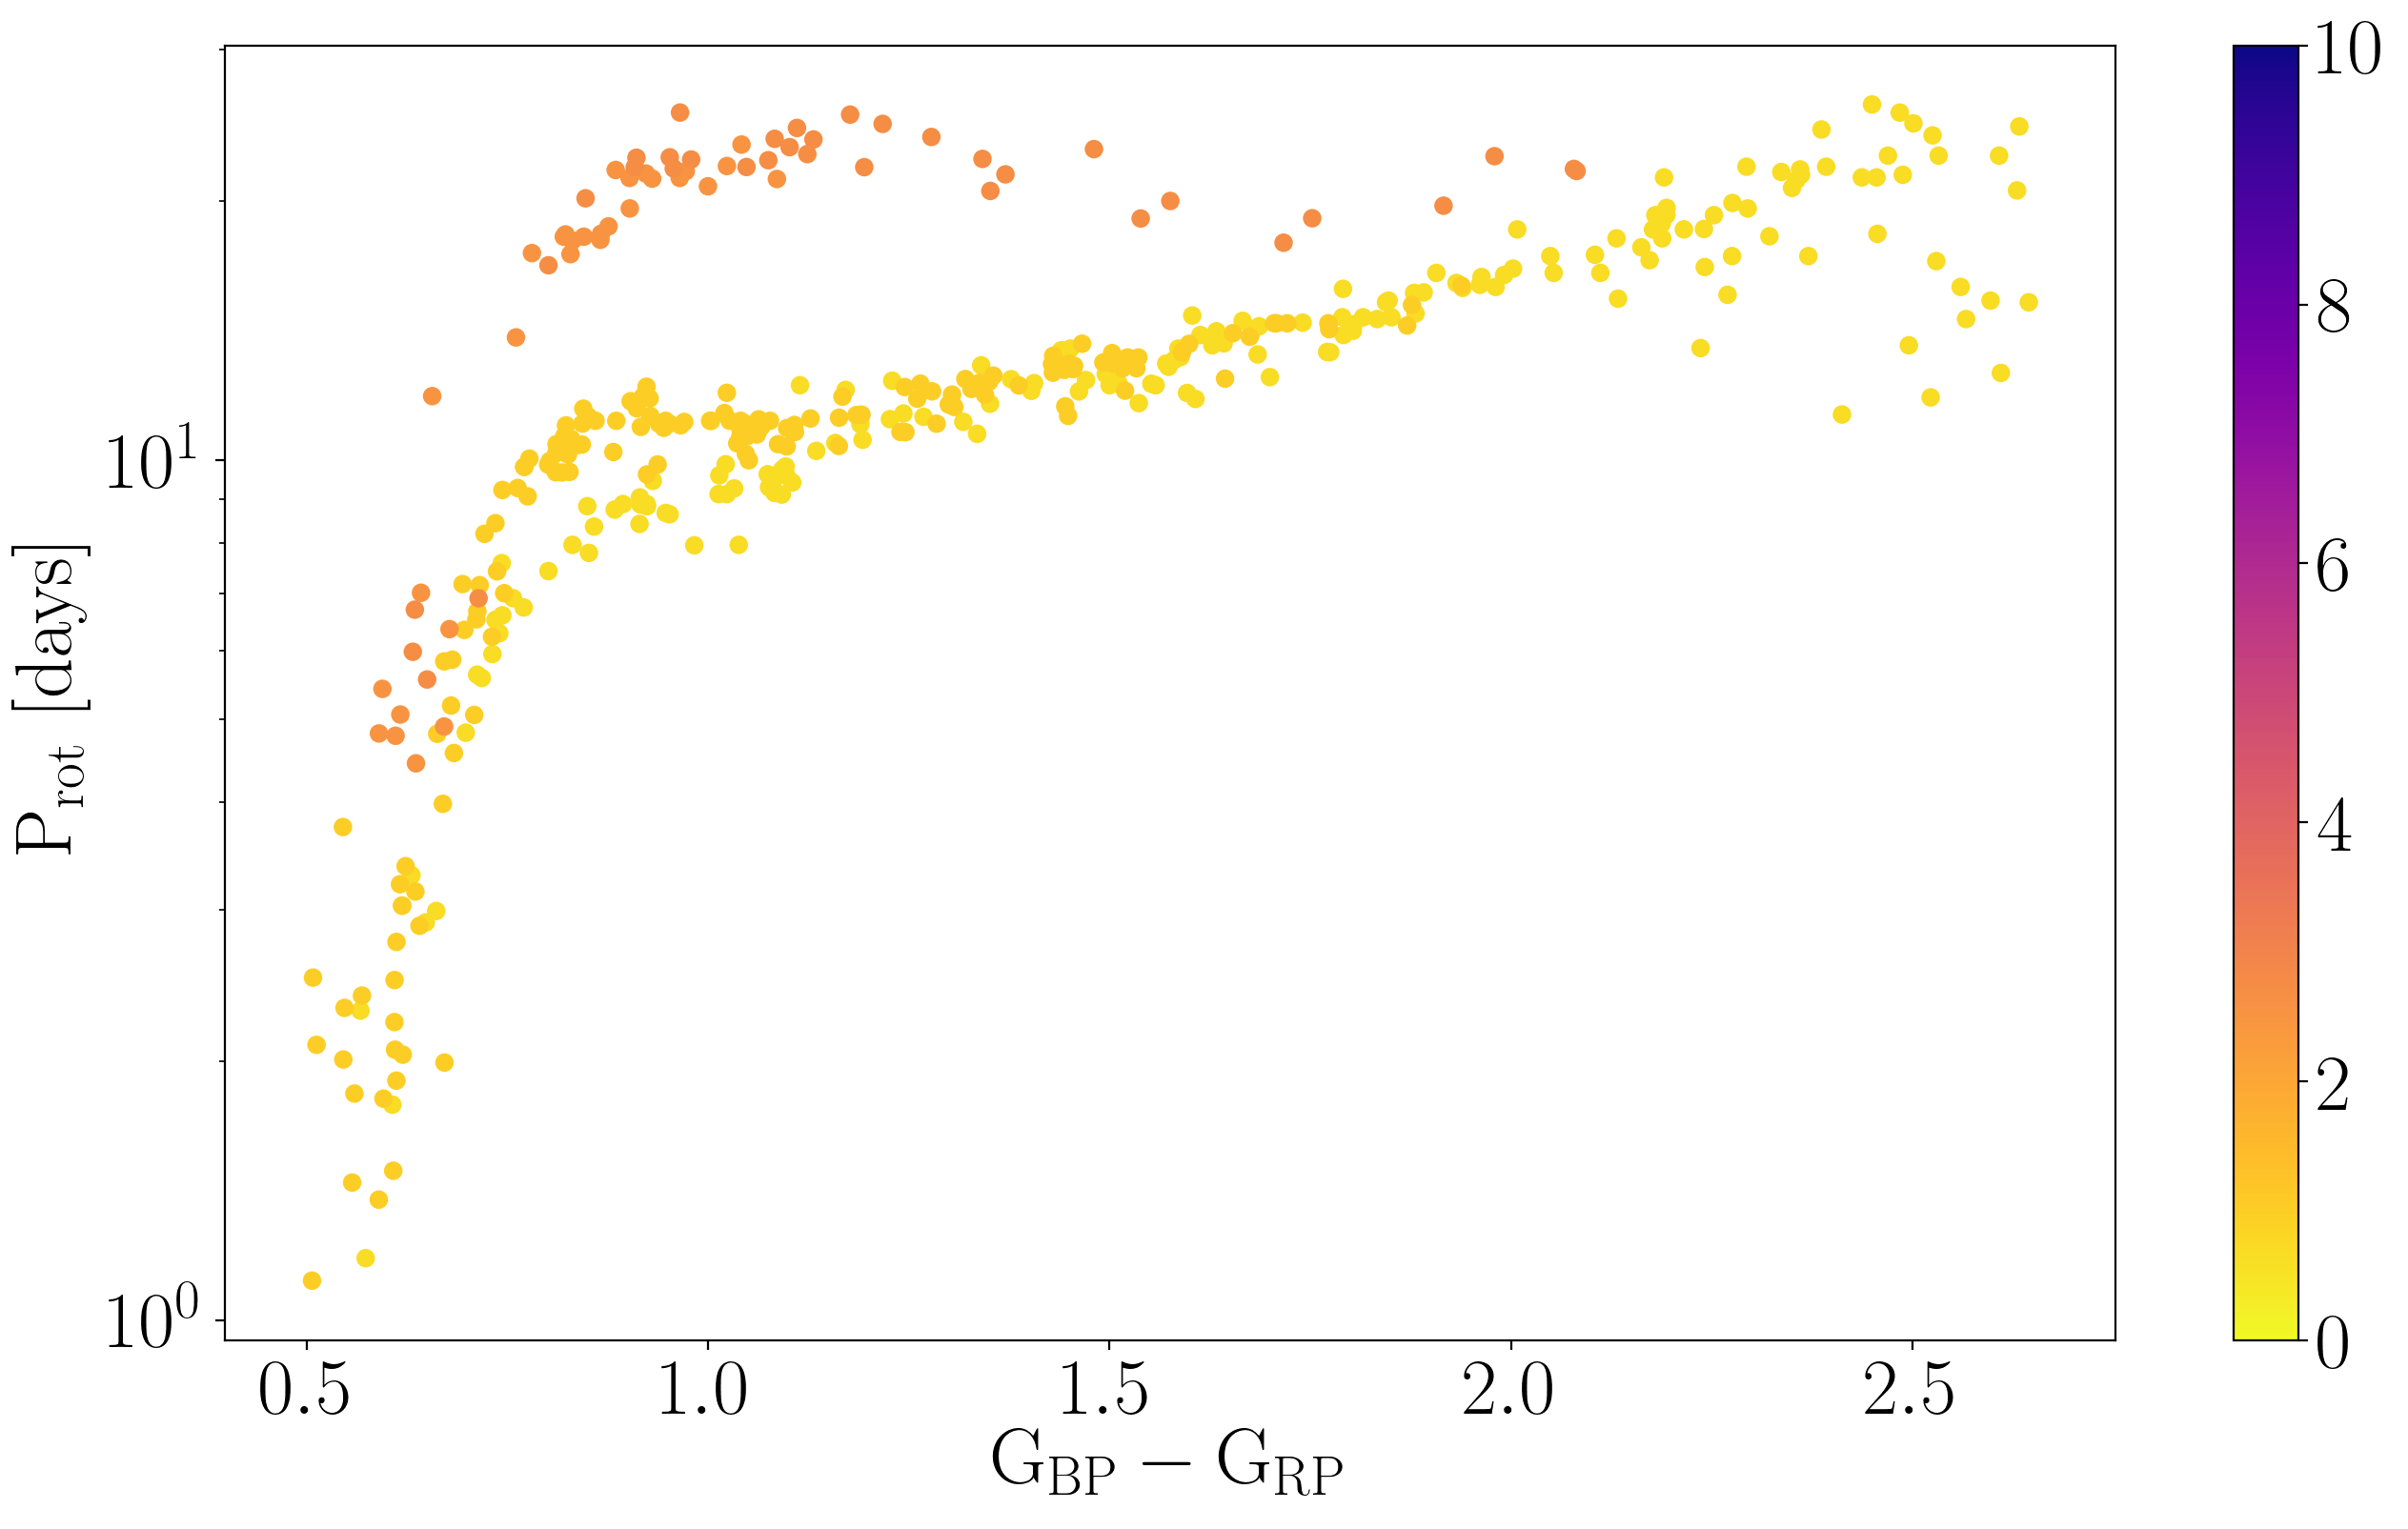

In [52]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(x, prot, c=age, vmin=0, vmax=10, cmap="plasma_r")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.colorbar();

Sort and format data

In [53]:
# without mearth
# inds = np.argsort(data.teff.values)
# x1 = np.array(data.teff.values[inds])
# x2 = np.log(np.array(data.age_gyr.values[inds]))
# y = np.log(np.array(data.period.values[inds]))

# with mearth
# teff = np.concatenate((data.teff.values, mdf.teff.values))
# age = np.concatenate((data.age_gyr.values, mdf.kin_age.values))
# prot = np.concatenate((data.period.values, mdf.prot.values))

In [54]:
inds = np.argsort(x)
x1 = np.array(x[inds])
x2 = np.log(np.array(age[inds]))
y = np.log(np.array(prot[inds]))

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)
# x1_norm = (x1 - mu1) / sd1
# x2_norm = (x2 - mu2) / sd2

x2_min = np.min(x2)

# if using Teff:
# xp1 = np.linspace(x1.min() - 500, x1.max() + 100, 1000)

# if using color:
xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)

xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
# xg2 = np.linspace(x2.min(), x2.max(), 7)
xg2 = np.linspace(x2.min(), x2.max(), 10)  # More age lines

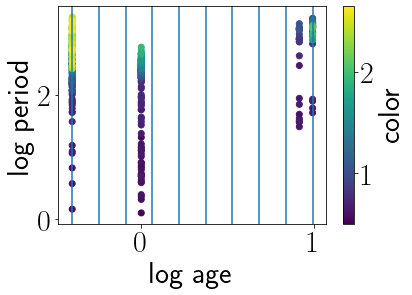

In [55]:
plt.scatter(x2, y, c=x1)
for i, x2_ref in enumerate(xg2):
    plt.axvline(x2_ref)
plt.xlabel("log age")
plt.ylabel("log period")
plt.colorbar(label="color")

In [56]:
with pm.Model() as model:
    
#     teff_break = pm.Normal("teff_break", mu=6000, sigma=500)
    teff_break = pm.Normal("teff_break", mu=0.9, sigma=.3)
    log_period_break_c = pm.Normal("log_period_break_c", mu=0.0, sd=5)
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)
    smooth = tt.exp(log_smooth)
    
    def get_log_period_break(x2):
        """
        3rd-order polynomial describing relationship between period and age.
        period = c*logage**2 + m*logage + b
        """
        return log_period_break_c * (x2 - x2_min)**2 + log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)
    
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)
    
    # Mean model
    def get_mean_model(x1, x2):
        delta = x1 - teff_break
        brk = get_log_period_break(x2)
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # GP
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10.0, shape=2)
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = np.vstack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    for i, x2_ref in enumerate(xg2):
        pred_model = get_mean_model(xp1, x2_ref)
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
    
#     x1_test = pm.Flat("x1_test", shape=(1,))
#     x2_test = pm.Flat("x2_test", shape=(1,))
#     K_test = get_K(x1, x2, x1_test, x2_test)
#     y_test = pm.Deterministic("y_test", tt.dot(K_test, alpha) + get_mean_model(x1_test, x2_test))
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b, log_period_break_c])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln)

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -614.7335046276047 -> -612.7090430988752
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -612.7090430988752 -> -612.2656804167335
optimizing logp for variables: [log_period_break_c, log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -612.2656804167335 -> -611.7055015696418
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -611.7055015696418 -> -609.0034437205728
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -609.0034437205728 -> 153.23807095893227
optimizing logp for variables: [log_ell1, log_amp, log_s2, slope_high, slope_low, log_smooth, log_period_break_b, log_period_break_m, log_period_break_c, teff_break]


message: Optimization terminated successfully.
logp: 153.23807095893227 -> 168.30561231949386


In [60]:
print(map_soln['slope_low'], map_soln['slope_high'])
print(map_soln['log_smooth'], map_soln['teff_break'])
print(map_soln['log_period_break_m'], map_soln['log_period_break_b'], map_soln['log_period_break_c'])

5.450895570296598 0.39344213013007623
2.7340900980951024 0.8353259228179608
0.11937796179356984 2.2514239043929574 0.21045108500066642


In [57]:
# import pickle
# with open("../data/gp_model_bprp_12-10-20.pkl", "wb") as f:
#     pickle.dump([model, map_soln], f)

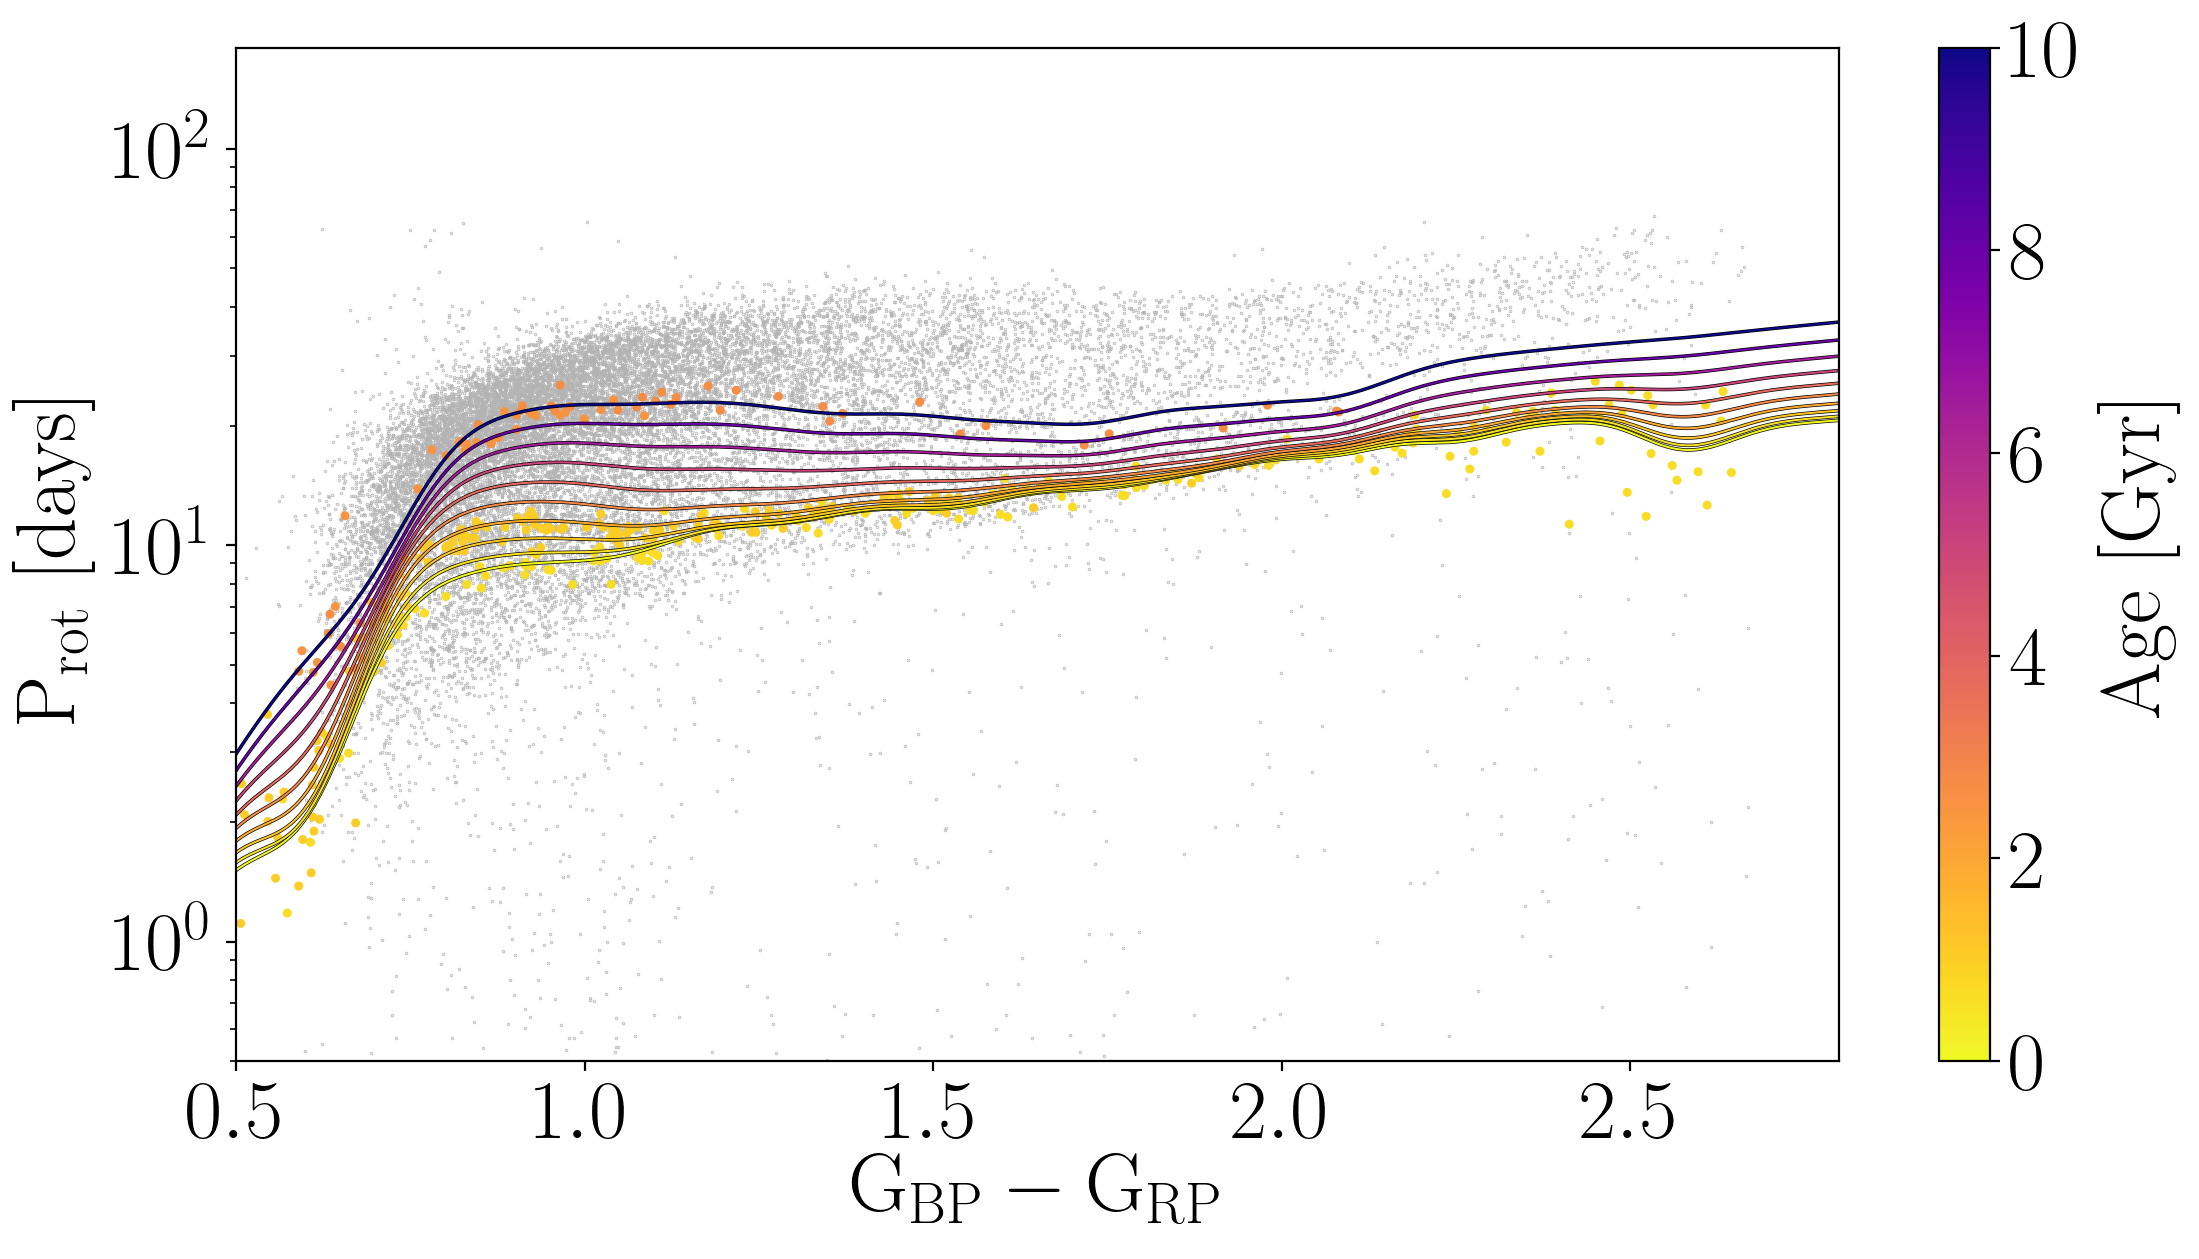

In [58]:
cmap = matplotlib.cm.get_cmap("plasma_r")

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(12, 7), dpi=200)
plt.plot(kin.bprp_dered, kin.Prot, ".", color=".7", zorder=0, ms=.5, rasterized=True)
plt.scatter(x, prot, c=age, vmin=0, vmax=10, s=5, cmap="plasma_r")

for i in range(len(xg2)):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");
plt.xlim(.5, 2.8)
plt.tight_layout()

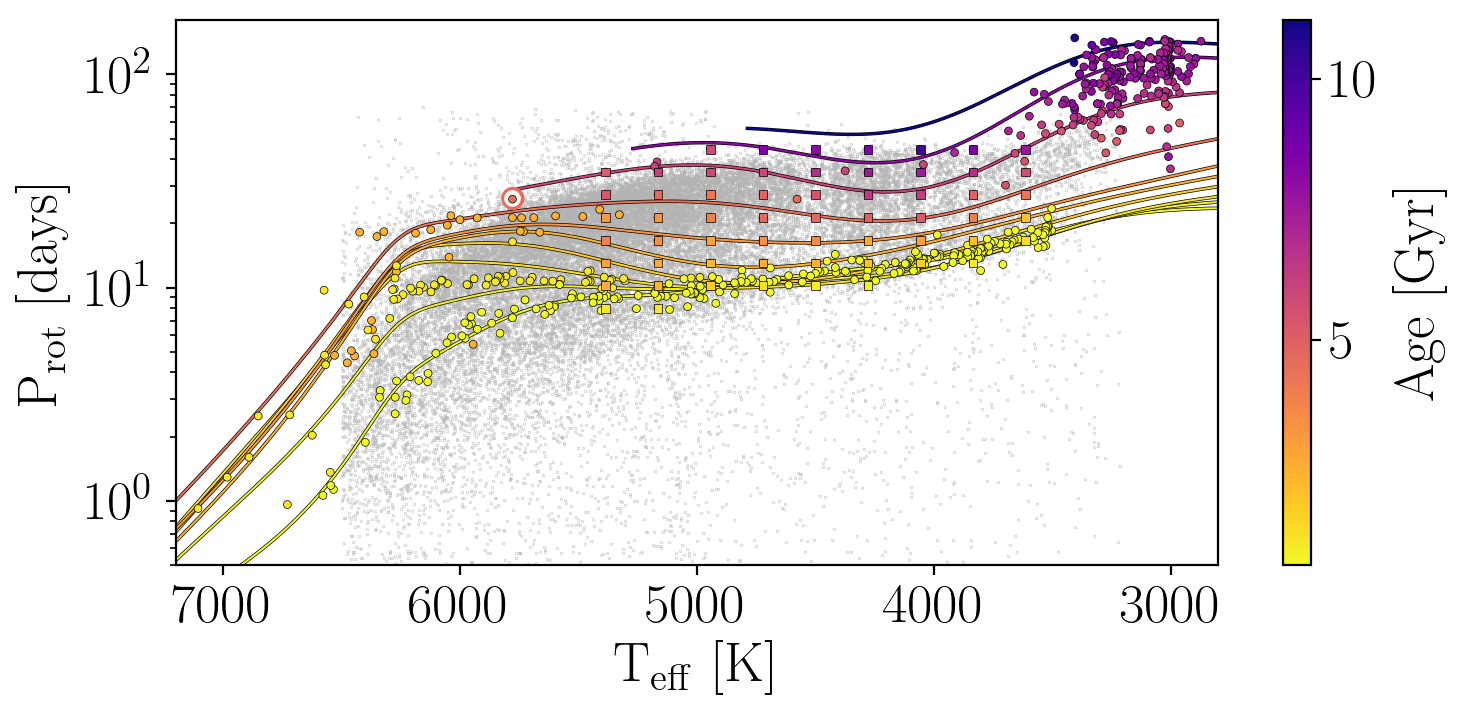

In [9]:
cmap = matplotlib.cm.get_cmap("plasma_r")


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

plt.plot(mcq.Teff, mcq.Prot, ".", color=".7", zorder=0, ms=.3, rasterized=True)

c = -500
for i in range(len(xg2)-1, len(xg2)):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -400
for i in range(len(xg2)-2, len(xg2)-1):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -300
for i in range(len(xg2)-3, len(xg2)-2):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)

for i in range(0, len(xg2)-3):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
            linewidth=0.25, zorder=100)
plt.scatter(data.teff.values[-60:-1], data.period.values[-60:-1], c=data.age_gyr.values[-60:-1], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, marker="s", edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=70, edgecolor="",
            linewidth=0.25, zorder=98)
plt.plot([data.teff.values[-1]+1], [data.period.values[-1]+.2], "wo", ms=5, zorder=99)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7200, 3400)
plt.xlim(7200, 2800)
# plt.ylim(0.5, 80)
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()
# plt.savefig("gp_demo_viridis")
# plt.savefig("gp_demo_viridis.pdf")
# plt.savefig("gp_demo_plasma")
# plt.savefig("gp_demo_plasma.pdf")
plt.savefig("gp_demo_mearth")
plt.savefig("gp_demo_mearth.pdf")

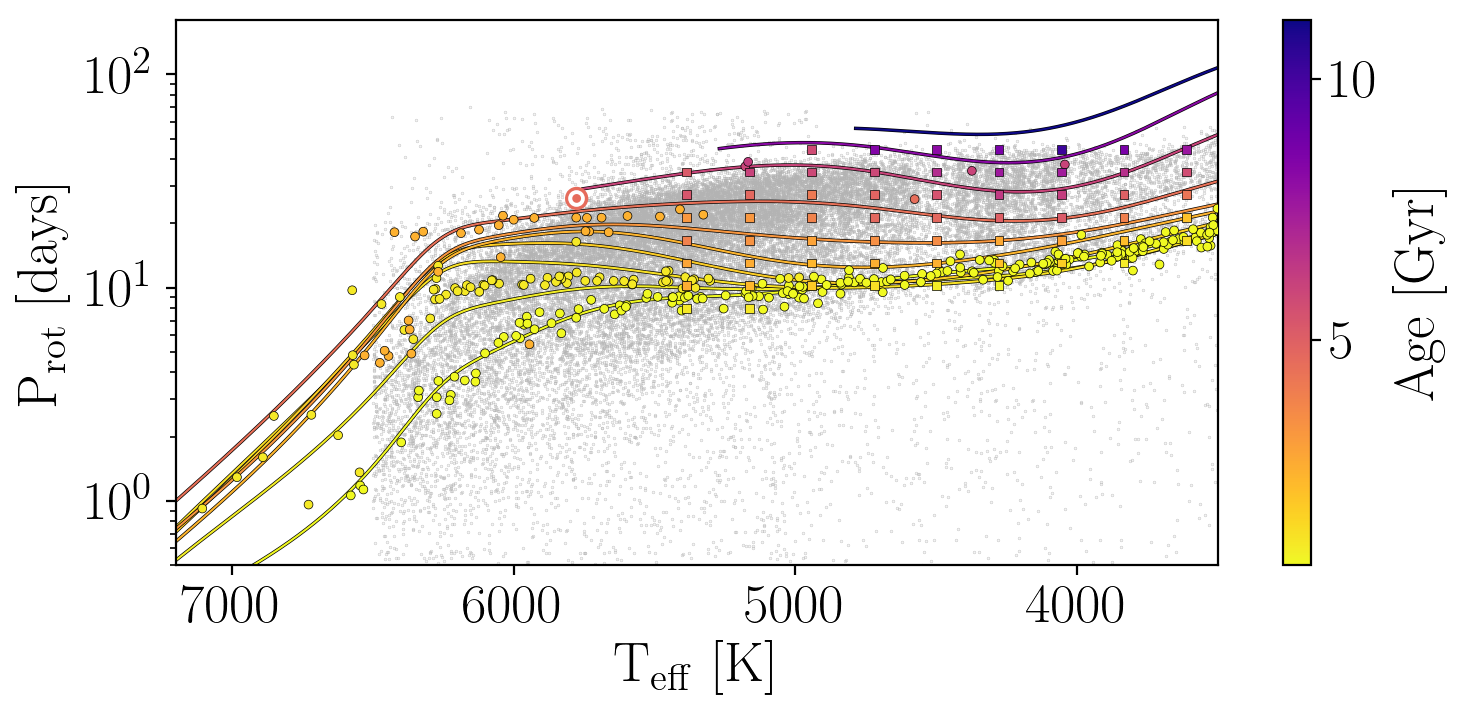

In [19]:
import matplotlib
# cmap = matplotlib.cm.get_cmap("viridis_r")
cmap = matplotlib.cm.get_cmap("plasma_r")


plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 15,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(8, 4), dpi=200)

plt.plot(mcq.Teff, mcq.Prot, ".", color=".7", zorder=0, ms=.3, rasterized=True)

# inds = np.argsort(x1)
# plt.plot(x1[inds], map_soln["mean_model"][inds], "k")

# for i, x2_ref in enumerate(xg2):
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
#     plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(x2_ref), lw=0.75)

c = -500
for i in range(len(xg2)-1, len(xg2)):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -400
for i in range(len(xg2)-2, len(xg2)-1):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)
    
c = -300
for i in range(len(xg2)-3, len(xg2)-2):
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color="k", lw=1.25)
    plt.plot(xp1[:c], np.exp(map_soln["pred_{0}".format(i)])[:c], color=get_color(xg2[i]), lw=0.75)

for i in range(0, len(xg2)-3):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

# plt.scatter(x1, np.exp(y), c=np.exp(x2), cmap=cmap, vmin=vmin, vmax=vmax, s=8, edgecolor="k",
#             linewidth=0.25, zorder=100)
plt.scatter(data.teff.values[:-60], data.period.values[:-60], c=data.age_gyr.values[:-60], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter(data.teff.values[-60:-1], data.period.values[-60:-1], c=data.age_gyr.values[-60:-1], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, marker="s", edgecolor="k", linewidth=0.25, zorder=101)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=70, edgecolor="",
            linewidth=0.25, zorder=98)
plt.plot([data.teff.values[-1]+1], [data.period.values[-1]+.2], "wo", ms=5, zorder=99)
plt.scatter([data.teff.values[-1]-1.5], [data.period.values[-1]+.2], c=[data.age_gyr.values[-1]], cmap=cmap,
            vmin=vmin, vmax=vmax, s=10, edgecolor="",
            linewidth=0.25, zorder=100)
    
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
# plt.xlim(7200, 3400)
plt.xlim(7200, 3500)
# plt.ylim(0.5, 80)
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");

plt.tight_layout()
plt.savefig("gp_demo_background")
plt.savefig("gp_demo_background.pdf")